# Omar Farooq
#### Data Analysis of 'Movies' & 'A4' dataset using spark dataframes 

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf

In [2]:
# create the session
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
# create the context
sc = pyspark.SparkContext(conf=conf)

In [3]:
spark = SparkSession(sc)

In [4]:
spark

##### Data Loading

In [5]:
df1 = spark.read.csv("MoviesA3.csv", sep= ";",inferSchema=True,header=True)

In [6]:
Data = sc.textFile("A4dataset2.txt")
Data = Data.map(lambda x: [int(i) for i in x.split(' ') if i not in ''])
#Data.collect()
df2 = Data.toDF(['x', 'y'])
df2.show(1)

+------+------+
|     x|     y|
+------+------+
|845753|636607|
+------+------+
only showing top 1 row



###### i. Identify the type of each data attribute. Indicate if the type of attribute is Nominal, Ordinal, Interval or Ratio

In [7]:
df1.dtypes

[('Year', 'int'),
 ('Length', 'int'),
 ('Title', 'string'),
 ('Genre', 'string'),
 ('Actor', 'string'),
 ('Actress', 'string'),
 ('Director', 'string'),
 ('Popularity', 'int'),
 ('Awards', 'string'),
 ('Image', 'string')]

In [8]:
df1.show(3)

+----+------+--------------------+------+-------------------+---------------+-----------------+----------+------+------------------+
|Year|Length|               Title| Genre|              Actor|        Actress|         Director|Popularity|Awards|             Image|
+----+------+--------------------+------+-------------------+---------------+-----------------+----------+------+------------------+
|1990|   111|Tie Me Up! Tie Me...|Comedy|  Banderas, Antonio|Abril, Victoria| Almod�var, Pedro|        68|    No|NicholasCage.png,,|
|1991|   113|          High Heels|Comedy|       Bos�, Miguel|Abril, Victoria| Almod�var, Pedro|        68|    No|NicholasCage.png,,|
|1983|   104|      Dead Zone, The|Horror|Walken, Christopher|  Adams, Brooke|Cronenberg, David|        79|    No| NicholasCage.png,|
+----+------+--------------------+------+-------------------+---------------+-----------------+----------+------+------------------+
only showing top 3 rows



### Movies Dataset
| Variable | type |
| --- | --- |
| Year | ratio |
| Length | ratio |
| Title | nominal |
| Genre | nominal |
| Actor | nominal |
| Actress | nominal |
| Director | nominal |
| Popularity | interval |
| Awards | ordinal |
| Image | nominal |

In [9]:
df2.show(2)

+------+------+
|     x|     y|
+------+------+
|845753|636607|
|812954|643720|
+------+------+
only showing top 2 rows



In [10]:
df2.dtypes

[('x', 'bigint'), ('y', 'bigint')]

### A4 Dataset
| Variable | type |
| --- | --- |
| x | ratio |
| y | ratio |

##### ii)a) Handle missing values

In [11]:
import pyspark.sql.functions as f

In [12]:
print('null values in x: ', df2.filter(df2.x.isNull()).count())
print('null values in y: ', df2.filter(df2.y.isNull()).count())

null values in x:  0
null values in y:  0


In [13]:
for c in df1.columns:
    print('null values in ', c, ': ', df1.filter(f.col(c).isNull()).count())

null values in  Year :  0
null values in  Length :  67
null values in  Title :  0
null values in  Genre :  2
null values in  Actor :  8
null values in  Actress :  378
null values in  Director :  253
null values in  Popularity :  6
null values in  Awards :  0
null values in  Image :  0


In [14]:
df1.count()

1659

In [15]:
nom = [c[0] for c in df1.dtypes if c[1]=='string'] 
df1= df1.na.fill('No', ['Awards'])

In [16]:
df1 = df1.na.drop(subset=nom)

In [17]:
from pyspark.sql.functions import sum,avg,max,min,mean,count
seq = [x for x in df1.columns if x not in nom]

In [18]:
for x in seq:
    meanValue = int(df1.agg(avg(x)).first()[0])
    print(x, meanValue)
    df1= df1.na.fill(meanValue, [x])

Year 1975
Length 108
Popularity 43


In [19]:
for c in df1.columns:
    print('null values in ', c, ': ', df1.filter(f.col(c).isNull()).count())

null values in  Year :  0
null values in  Length :  0
null values in  Title :  0
null values in  Genre :  0
null values in  Actor :  0
null values in  Actress :  0
null values in  Director :  0
null values in  Popularity :  0
null values in  Awards :  0
null values in  Image :  0


##### ii)b) Identify if an attribute has outliers or noise

### Movies Dataset

In [20]:

bounds = {
    c: dict(
        zip(["q1", "q3"], df1.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in seq
}

In [21]:
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
print(bounds)

{'Year': {'q1': 1966.0, 'q3': 1988.0, 'lower': 1933.0, 'upper': 2021.0}, 'Length': {'q1': 94.0, 'q3': 117.0, 'lower': 59.5, 'upper': 151.5}, 'Popularity': {'q1': 19.0, 'q3': 68.0, 'lower': -54.5, 'upper': 141.5}}


In [22]:
df3 = df1.select(
    "*",
    *[
        f.when(
            f.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in seq
    ]
)
droppy = df3.columns[-3:]
droppy

['Year_out', 'Length_out', 'Popularity_out']

In [23]:
print("total outliers: ", df3.filter(~df3[droppy[0]].rlike("[0]") | ~df3[droppy[1]].rlike("[0]") | ~df3[droppy[0]].rlike("[0]")).count())
{droppy[0] : df3.filter(~df3[droppy[0]].rlike("[0]")).count(), 
droppy[1] : df3.filter(~df3[droppy[1]].rlike("[0]")).count(),
droppy[2] : df3.filter(~df3[droppy[0]].rlike("[0]")).count()}

total outliers:  93


{'Year_out': 32, 'Length_out': 62, 'Popularity_out': 32}

### A4 Dataset

In [24]:
bounds1 = {
    c: dict(
        zip(["q1", "q3"], df2.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in df2.columns
}
for c in bounds1:
    iqr = bounds1[c]['q3'] - bounds1[c]['q1']
    bounds1[c]['lower'] = bounds1[c]['q1'] - (iqr * 1.5)
    bounds1[c]['upper'] = bounds1[c]['q3'] + (iqr * 1.5)
print(bounds1)

{'x': {'q1': 365668.0, 'q3': 725843.0, 'lower': -174594.5, 'upper': 1266105.5}, 'y': {'q1': 245409.0, 'q3': 696190.0, 'lower': -430762.5, 'upper': 1372361.5}}


In [25]:
df4 = df2.select(
    "*",
    *[
        f.when(
            f.col(c).between(bounds1[c]['lower'], bounds1[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in df2.columns
    ]
)
dropp = df4.columns[-2:]
dropp

['x_out', 'y_out']

In [26]:
print("total outliers: ", df4.filter(~df4[dropp[0]].rlike("[0]") | ~df4[dropp[1]].rlike("[0]")).count())
{dropp[0] : df4.filter(~df4[dropp[0]].rlike("[0]")).count(), 
dropp[1] : df4.filter(~df4[dropp[1]].rlike("[0]")).count()}

total outliers:  0


{'x_out': 0, 'y_out': 0}

##### c) Apply measures of the central tendency and dispersion to analyze numeric attributes. That is, compute the mean, median, mode, range, variance,correlation for the attribute. Don’t just give values explain analyze them.

### Movies Dataset

In [27]:
from pyspark.sql.functions import sum,avg,max,min,mean,count, variance, stddev

In [28]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=seq, outputCol=vector_col)
df_vector = assembler.transform(df1).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [29]:
matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape( (3,3 ) )

array([[ 1.        ,  0.07218621, -0.12048869],
       [ 0.07218621,  1.        , -0.02102639],
       [-0.12048869, -0.02102639,  1.        ]])

In [30]:
for c in seq:
    print("========== ", c, " ===========")
    print("avg: " + str(df1.select(avg(c)).collect()[0][0]))
    print("range: " + str(df1.select(max(c)).collect()[0][0]-df1.select(min(c)).collect()[0][0]))
    print("variance: " + str(df1.select(variance(c)).collect()[0][0]))
    print("mode: " + str(df1.groupby(c).count().orderBy("count", ascending=False).first()[0]))
    print("median: " + str(df1.approxQuantile(c, [0.5], 0)[0]))
    print("stddev: " + str(df1.select(stddev(c)).collect()[0][0]))
    
    

==========  Year  ===========
avg: 1975.164644714038
range: 74
variance: 280.05092584937876
mode: 1987
median: 1982.0
stddev: 16.73472216230012
==========  Length  ===========
avg: 108.18457538994801
range: 432
variance: 843.5209760988212
mode: 90
median: 103.0
stddev: 29.04343258120192
==========  Popularity  ===========
avg: 43.773830155979205
range: 88
variance: 720.343425560026
mode: 8
median: 44.0
stddev: 26.839214324566694


### A4 dataset

In [31]:
df2.stat.corr("x", "y")

0.13278911382081576

In [32]:
for c in df2.columns:
    print("========== ", c, " ===========")
    print(" avg: " + str(df2.select(avg(c)).collect()[0][0]))
    print(" range: " + str(df2.select(max(c)).collect()[0][0]-df2.select(min(c)).collect()[0][0]))
    print(" variance: " + str(df2.select(variance(c)).collect()[0][0]))
    print(" mode: " + str(df2.groupby(c).count().orderBy("count", ascending=False).first()[0]))
    print(" median: " + str(df2.approxQuantile(c, [0.5], 0)[0]))
    print(" stddev: " + str(df2.select(stddev(c)).collect()[0][0]))
    
    

==========  x  ===========
 avg: 525659.3564
 range: 928001
 variance: 48738478796.204254
 mode: 684997
 median: 539226.0
 stddev: 220767.92972758578
==========  y  ===========
 avg: 477365.5364
 range: 958924
 variance: 54680634245.28494
 mode: 777579
 median: 471635.0
 stddev: 233838.90661154944


##### d) Would you apply preprocessing techniques like discretization or normalization on any attribute? Explain your answer. If yes, then apply the technique and share the results.

### Movies Dataset

| Variable | Pre-processing | Reason |
| --- | --- | --- |
| Length   | Binning + Normalization | Remove Noise + Rescale |
| Popularity   | Binning + Normalization | Remove Noise + Rescale |
| Year | Binning + Normalization | Remove Noise + Rescale |

In [37]:
# Binning by bin-boundaries
from pyspark.ml.feature import QuantileDiscretizer
import numpy as np

df3 = df1

dic = {}
for col in seq:
    num = list(range(42))
    val = df1.approxQuantile(col, list(np.arange(0,1.025,0.025)), 0)
    res = dict(zip(num, val))  
    dic[col] = val
    


In [38]:
# Binning by bin-boundaries
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

 
    
def add_des(colu, dictionary):
    def f(org):
        i = 0
        llen = len(dictionary[colu])
        while(1):
            bin1 = int(dictionary[colu][i])
            bin2 = int(dictionary[colu][i+1])
            
            #case 1: both are larger
            if(org-bin1 > 0 and org-bin2 > 0):
                
                if(i < llen-2):
                    i = i+1
                    bin1 = int(dictionary[colu][i])
                    bin2 = int(dictionary[colu][i+1])
                else:
                    return int(dictionary[colu][llen-1])
            #case 2: val in between
            elif(org-bin1 > 0 and org-bin2 < 0):
                break
            else:
                print("Error in binning by bin-boundaries")
                break

        if abs(org-bin1) < abs(org-bin2):
            return bin1
        else:
            return bin2
    return udf(f, IntegerType())

for colu in seq:
    df3 = df3.withColumn(colu , add_des(colu, dic)(f.col(colu)))
df3.show(3)

+----+------+--------------------+------+-------------------+---------------+-----------------+----------+------+------------------+
|Year|Length|               Title| Genre|              Actor|        Actress|         Director|Popularity|Awards|             Image|
+----+------+--------------------+------+-------------------+---------------+-----------------+----------+------+------------------+
|1990|   111|Tie Me Up! Tie Me...|Comedy|  Banderas, Antonio|Abril, Victoria| Almod�var, Pedro|        68|    No|NicholasCage.png,,|
|1991|   113|          High Heels|Comedy|       Bos�, Miguel|Abril, Victoria| Almod�var, Pedro|        68|    No|NicholasCage.png,,|
|1983|   105|      Dead Zone, The|Horror|Walken, Christopher|  Adams, Brooke|Cronenberg, David|        80|    No| NicholasCage.png,|
+----+------+--------------------+------+-------------------+---------------+-----------------+----------+------+------------------+
only showing top 3 rows



In [39]:
# Normalizing
agg = {"mean":{}, "stdev":{}}

for column in seq:
    agg["mean"][column]= df3.select(avg(column)).collect()[0][0]
    agg["stdev"][column] = df3.select(stddev(column)).collect()[0][0]

    # Standardise each dataframe, column by column
for column in seq:            
    # Standardise the TRAINING data
    df3 = df3.withColumn(column, ((df3[column] - agg["mean"][column]) / agg["stdev"][column]))       

df3.show(3)

+-------------------+--------------------+--------------------+------+-------------------+---------------+-----------------+------------------+------+------------------+
|               Year|              Length|               Title| Genre|              Actor|        Actress|         Director|        Popularity|Awards|             Image|
+-------------------+--------------------+--------------------+------+-------------------+---------------+-----------------+------------------+------+------------------+
| 0.8826760689094908| 0.11395001849328577|Tie Me Up! Tie Me...|Comedy|  Banderas, Antonio|Abril, Victoria| Almod�var, Pedro|0.8900255566545787|    No|NicholasCage.png,,|
|  0.942746139294674| 0.18680227408400704|          High Heels|Comedy|       Bos�, Miguel|Abril, Victoria| Almod�var, Pedro|0.8900255566545787|    No|NicholasCage.png,,|
|0.46218557621320905|-0.10460674827887799|      Dead Zone, The|Horror|Walken, Christopher|  Adams, Brooke|Cronenberg, David|1.3357625610505357|    No|

### A4 Dataset

In [40]:
# Binning by bin-boundaries
df4 = df2

seqe = df4.columns[:2]
dic1 = {}
for col in seqe:
    val = df4.approxQuantile(col, list(np.arange(0,1.025,0.025)), 0)
    dic1[col] = val
    

for colu in seqe:
    df4 = df4.withColumn(colu , add_des(colu, dic1)(f.col(colu)))
df4.show(3)

+------+------+
|     x|     y|
+------+------+
|837052|641107|
|813325|641107|
|855489|610420|
+------+------+
only showing top 3 rows



In [43]:
# Normalizing
agg1 = {"mean":{}, "stdev":{}}

for column in seqe:
    agg1["mean"][column]= df4.select(avg(column)).collect()[0][0]
    agg1["stdev"][column] = df4.select(stddev(column)).collect()[0][0]

    # Standardise each dataframe, column by column
for column in seqe:            
    # Standardise the TRAINING data
    df4 = df4.withColumn(column, ((df4[column] - agg1["mean"][column]) / agg1["stdev"][column]))       

df4.show(3)

+-----------------+------------------+
|                x|                 y|
+-----------------+------------------+
|1.416054646932836|0.7025199888219215|
|1.308243143994456|0.7025199888219215|
| 1.49982927835168|0.5708864911965532|
+-----------------+------------------+
only showing top 3 rows



# 
##### a) Cluster the Movies dataSet using atmost three attributes to avoid curse of dimentionality. You can select the attribute based on the preprocessing.

In [44]:
vecAssembler = VectorAssembler(inputCols=seq, outputCol="features")
new_df = vecAssembler.transform(df3)
new_df.show(3)

+-------------------+--------------------+--------------------+------+-------------------+---------------+-----------------+------------------+------+------------------+--------------------+
|               Year|              Length|               Title| Genre|              Actor|        Actress|         Director|        Popularity|Awards|             Image|            features|
+-------------------+--------------------+--------------------+------+-------------------+---------------+-----------------+------------------+------+------------------+--------------------+
| 0.8826760689094908| 0.11395001849328577|Tie Me Up! Tie Me...|Comedy|  Banderas, Antonio|Abril, Victoria| Almod�var, Pedro|0.8900255566545787|    No|NicholasCage.png,,|[0.88267606890949...|
|  0.942746139294674| 0.18680227408400704|          High Heels|Comedy|       Bos�, Miguel|Abril, Victoria| Almod�var, Pedro|0.8900255566545787|    No|NicholasCage.png,,|[0.94274613929467...|
|0.46218557621320905|-0.10460674827887799|   

In [45]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(new_df)
    
    output=KMeans_fit.transform(new_df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score with", i,"clusters:",score)

Silhouette Score with 2 clusters: 0.4218322323111163
Silhouette Score with 3 clusters: 0.4913696021696762
Silhouette Score with 4 clusters: 0.4559124658930528
Silhouette Score with 5 clusters: 0.5229555502516077
Silhouette Score with 6 clusters: 0.4314207286992868
Silhouette Score with 7 clusters: 0.45242988302139786
Silhouette Score with 8 clusters: 0.496149234019367
Silhouette Score with 9 clusters: 0.4313614001720789


In [54]:
import pandas as pd
pd.DataFrame(silhouette_score).head(9)

,0
0,0.421832
1,0.491370
2,0.455912
3,0.522956
4,0.431421
5,0.452430
6,0.496149
7,0.431361


Text(0, 0.5, 'cost')

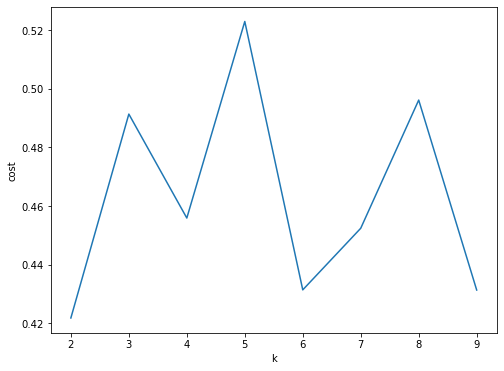

In [46]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

###### The Movies dataset therefore has 5 clusters, as a maxima is observed at k=5

In [50]:
KMeans_algo=KMeans(featuresCol='features', k=5)    
KMeans_fit=KMeans_algo.fit(new_df) 
output=KMeans_fit.transform(new_df)
score=evaluator.evaluate(output)
    
print("Cluster Centers: ")
ctr=[]
centers = KMeans_fit.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[-1.85772986 -0.43470088  0.85201697]
[ 0.59372363 -0.05463757 -0.95283028]
[ 0.43317214 -0.04918287  0.84024654]
[-1.12428039 -0.20221009 -0.70648439]
[-0.1985852   3.43735489  0.0356963 ]


In [59]:
c1 = [(list[0]*16.73472216230012+1975.164644714038, list[1]*29.04343258120192+108.18457538994801, list[2]*26.839214324566694+43.773830155979205)for list in ctr]
# centers without standardization  
pd.DataFrame(c1, columns=seq).head(9)

,Year,Length,Popularity
0,1944.076052,95.559370,66.641296
1,1985.100445,106.597713,18.200614
2,1982.413660,106.756136,66.325387
3,1956.350125,102.311700,24.812344
4,1971.841377,208.017160,44.731891


### A4 Dataset

In [47]:
vecAssembler = VectorAssembler(inputCols=seqe, outputCol="features")
a4df = vecAssembler.transform(df4)
a4df.show()

+------------------+-------------------+--------------------+
|                 x|                  y|            features|
+------------------+-------------------+--------------------+
| 1.416054646932836| 0.7025199888219215|[1.41605464693283...|
| 1.308243143994456| 0.7025199888219215|[1.30824314399445...|
|  1.49982927835168| 0.5708864911965532|[1.49982927835168...|
|2.0819850399930697| 0.5708864911965532|[2.08198503999306...|
| 1.416054646932836| 0.7025199888219215|[1.41605464693283...|
| 1.416054646932836| 0.5037078094645204|[1.41605464693283...|
| 1.308243143994456| 0.6226828376568236|[1.30824314399445...|
|  1.49982927835168| 0.7025199888219215|[1.49982927835168...|
|  1.49982927835168| 0.7025199888219215|[1.49982927835168...|
|1.2817435155063777| 0.7025199888219215|[1.28174351550637...|
|1.3591522382297831|0.27164730866500303|[1.35915223822978...|
| 1.416054646932836| 0.8093384252238804|[1.41605464693283...|
|  1.49982927835168| 0.6226828376568236|[1.49982927835168...|
|  1.499

In [48]:

silhouette_score1=[]
evaluator1 = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo1=KMeans(featuresCol='features', k=i)
    
    KMeans_fit1=KMeans_algo1.fit(a4df)
    
    output1=KMeans_fit1.transform(a4df)
    
    
    
    score1=evaluator1.evaluate(output1)
    
    silhouette_score1.append(score1)
    
    print("Silhouette Score with", i,"clusters:",score1)

Silhouette Score with 2 clusters: 0.556973658296425
Silhouette Score with 3 clusters: 0.5342499370437489
Silhouette Score with 4 clusters: 0.6314232878769717
Silhouette Score with 5 clusters: 0.5922052225509452
Silhouette Score with 6 clusters: 0.5507324533392449
Silhouette Score with 7 clusters: 0.5984819863538758
Silhouette Score with 8 clusters: 0.5741286529809043
Silhouette Score with 9 clusters: 0.5934227538755038


In [55]:
pd.DataFrame(silhouette_score1).head(9)

,0
0,0.556974
1,0.534250
2,0.631423
3,0.592205
4,0.550732
5,0.598482
6,0.574129
7,0.593423


Text(0, 0.5, 'cost')

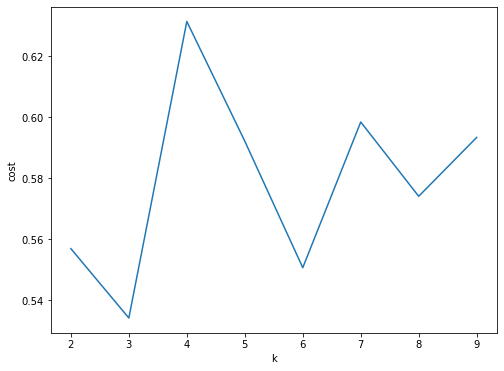

In [49]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score1)
ax.set_xlabel('k')
ax.set_ylabel('cost')

The A4 dataset again has 4 clusters as a local maxima can be seen at k=4

In [52]:
KMeans_algo1=KMeans(featuresCol='features', k=4)    
KMeans_fit1=KMeans_algo1.fit(a4df) 
output1=KMeans_fit1.transform(a4df)
score1=evaluator1.evaluate(output1)
    
print("Silhouette Score with 4 clusters:",score1)
print("Cluster Centers: ")
ctr1=[]
centers = KMeans_fit1.clusterCenters()
for center in centers:
    ctr1.append(center)
    print(center)

Silhouette Score with 4 clusters: 0.6314232878769717
Cluster Centers: 
[1.04064191 0.81681416]
[ 0.59248934 -0.94468491]
[-0.53024152  1.07339461]
[-1.13168987 -0.65275969]


In [56]:
c2 = [(list[0]*220767.92972758578+525659.3564, list[1]*233838.90661154944+477365.5364)for list in ctr1]
# centers without standardization    
pd.DataFrame(c2).head(9)

,0,1
0,755399.715457,668368.467558
1,656462.001886,256461.449351
2,408599.033150,728366.958444
3,275818.527401,324724.923059


# The End